In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, trange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
# import resnet18 model from pytorch
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter
import mxnet as mx
from mxnet import recordio
import torch.multiprocessing as mp
from sklearn.model_selection import train_test_split
from collections import defaultdict
import logging
import cv2
from facenet_pytorch import MTCNN

In [2]:
DIM = (112, 96)
BS = 256
EPOCHS = 30
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_CLASSES = 10572
NUM_WORKERS = 4
LOG_INTERVAL = 6

In [3]:
# Initialize the MTCNN face detector
mtcnn = MTCNN(keep_all=False, device='cuda:1')

# Function to perform face detection and crop face from image
def detect_and_crop_face(image, mtcnn, preprocess):
    # Convert image to PIL format if it's not already
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    elif isinstance(image, torch.Tensor):
        print("Converting torch tensor to PIL image")
        image = transforms.ToPILImage()(image)
    elif not isinstance(image, Image.Image):
        raise ValueError("Input image must be a numpy array, torch tensor, or PIL Image.")
    # Ensure the image is in RGB format
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Detect face bounding box using MTCNN
    # Note: mtcnn.detect returns boxes and probabilities.
    boxes, _ = mtcnn.detect(image)
    
    if boxes is not None:
        # Optionally choose the first detected face (or the one with highest score)
        box = boxes[0]
        # Crop the face using the bounding box and ensure it's in integer format
        cropped_face = image.crop((int(box[0]), int(box[1]), int(box[2]), int(box[3])))
        # You might want to add some padding or handle multiple faces based on your use-case.
    else:
        # If no face is detected return the original image or handle accordingly
        print(f"No face detected in. Using the original image.")
        cropped_face = image  # Convert to CxHxW format for PyTorch

    # Preprocess the cropped image
    # cropped_face = apply_clahe_pil(cropped_face, gray=False)
    return preprocess(cropped_face)

In [4]:
# class CASIAWebFaceDataset(Dataset):
#     def __init__(self, path_imgrec, transform=None):
#         self.transform = transform
#         assert path_imgrec
#         if path_imgrec:
#             logging.info('loading recordio %s...',
#                          path_imgrec)
#             path_imgidx = path_imgrec[0:-4] + ".idx"
#             print(path_imgrec, path_imgidx)
#             self.imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
#             s = self.imgrec.read_idx(0)
#             header, _ = recordio.unpack(s)
#             if header.flag > 0:
#                 print('header0 label', header.label)
#                 self.header0 = (int(header.label[0]), int(header.label[1]))
#                 # assert(header.flag==1)
#                 # self.imgidx = range(1, int(header.label[0]))
#                 self.imgidx = []
#                 self.id2range = {}
#                 self.seq_identity = range(int(header.label[0]), int(header.label[1]))
#                 for identity in self.seq_identity:
#                     s = self.imgrec.read_idx(identity)
#                     header, _ = recordio.unpack(s)
#                     a, b = int(header.label[0]), int(header.label[1])
#                     count = b - a
#                     self.id2range[identity] = (a, b)
#                     self.imgidx += range(a, b)
#                 print('id2range', len(self.id2range))
#             else:
#                 self.imgidx = list(self.imgrec.keys)
#             self.seq = self.imgidx

#     def __getitem__(self, idx):
#         # Map global index to class ID and local index
#         actual_idx = idx + 1  # MXNet indices start from 1
        
#         # Read record
#         header, s = recordio.unpack(self.imgrec.read_idx(actual_idx))
#         img = mx.image.imdecode(s).asnumpy()
#         label = int(header.label)
        
#         # # Convert to PIL and apply transforms
#         img = Image.fromarray(img)
#         if self.transform:
#             img = self.transform(img)
        
#         return img, label

#     def __len__(self):
#         return len(self.seq)

In [5]:
class CASIAWebFaceDataset(Dataset):
    def __init__(self, path_dataset, transform=None):
        self.transform = transform
        # the dataset is a folder with subfolders. The subfolder name is the label,
        # and the images are in the subfolder. Images represent their index in dataset.
        self.imgs = []
        self.labels = []
        
        # get all subfolders in the dataset folder
        subfolders = [f.path for f in os.scandir(path_dataset) if f.is_dir()]
        # get all images in the subfolders
        for label, subfolder in enumerate(subfolders):
            for img_file in os.listdir(subfolder):
                if img_file.endswith('.jpg') or img_file.endswith('.png'):
                    self.imgs.append(os.path.join(subfolder, img_file))
                    self.labels.append(label)
        self.imgs = np.array(self.imgs)
        self.labels = np.array(self.labels)
        self.seq = np.arange(len(self.imgs))
        self.id2range = defaultdict(list)
        for i, label in enumerate(self.labels):
            self.id2range[label].append(i)
        self.seq_identity = np.unique(self.labels)
        self.imgidx = np.arange(len(self.imgs))

    def __getitem__(self, idx):
        # Map global index to class ID and local index
        actual_idx = idx
        
        # Read image
        img = Image.open(self.imgs[actual_idx])
        label = int(self.labels[actual_idx])
        
        # Convert to PIL and apply transforms
        if self.transform:
            img = self.transform(img)
        
        return img, label
    def __len__(self):
        return len(self.seq)
    def get_imgidx(self):
        return self.imgidx

In [6]:
class CustomNormalize:
    def __call__(self, img):
        # Convert PIL image to tensor
        img = transforms.ToTensor()(img)
        # Subtract 128 and divide by 128
        img = (img * 255.0 - 127.5) / 128.0
        return img

class Cutout(object):
    """Randomly masks out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).

        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(DIM, scale=(0.08, 1.0)),  # Randomly crop the image to the specified size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 10 degrees
    # transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change brightness, contrast, saturation and hue
    CustomNormalize(),
    # Cutout(n_holes=1, length=16),  # Randomly cut out a square patch
])

test_preprocess = transforms.Compose([
    transforms.Resize(DIM),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    CustomNormalize()
])

Dataset size:  490623
Number of classes:  10572


Converting torch tensor to PIL image


torch.Size([1, 3, 112, 112]) tensor([9178])


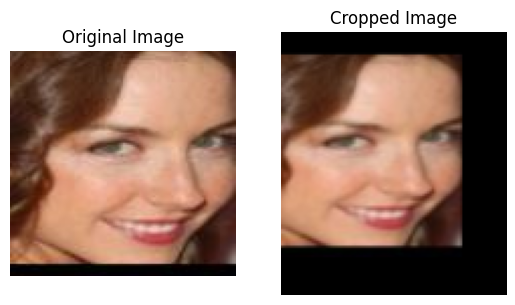

In [7]:
# get a sample from dataset
# dataset = CASIAWebFaceDataset(path_imgrec='./faces_webface_112x112/train.rec', transform=transforms.Compose([
#     transforms.ToTensor(),
# ]))
dataset = CASIAWebFaceDataset(path_dataset='./faces_webface_112x112_cropped', transform=transforms.Compose([
    transforms.ToTensor(),
]))
print("Dataset size: ", len(dataset))
print("Number of classes: ", len(dataset.seq_identity))

loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=NUM_WORKERS)
img, label = next(iter(loader))
cropped_face = detect_and_crop_face(img[0], mtcnn, transforms.Compose([
    transforms.Resize(DIM),
    transforms.ToTensor(),
]))
imgage = img[0].permute(1, 2, 0)
# imgage = Cutout(n_holes=1, length=16)(imgage)
print(img.size(), label)
# plot both images
plt.subplot(1, 2, 1)
plt.imshow(imgage)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cropped_face.permute(1, 2, 0).cpu().numpy())
plt.title("Cropped Image")
plt.axis('off')
plt.show()
# print(cropped_face.size())


# assert False


In [8]:
class AMSoftmax(nn.Module):
    '''
    The am softmax as seen on https://arxiv.org/pdf/1801.05599.pdf,

        in_features: size of the embedding, eg. 512
        n_classes: number of classes on the classification task
        s: s parameter of loss, standard = 30.
        m: m parameter of loss, standard = 0.4, best between 0.35 and 0.4 according to paper.

        *inputs: tensor shaped (batch_size X embedding_size)
        output : tensor shaped (batch_size X n_classes) AM_softmax logits for NLL_loss.

    '''
    def __init__(self, in_features, n_classes, s=30, m=0.35):
        super(AMSoftmax, self).__init__()
        self.linear = nn.Linear(in_features, n_classes, bias=False)
        self.s = s
        self.m = m

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, *inputs):
        # x_vector = F.normalize(inputs[0], p=2, dim=-1)
        # self.linear.weight.data = F.normalize(self.linear.weight.data, p=2, dim=-1, eps=1e-10)
        # logits = self.linear(x_vector)
        x_vector = inputs[0]
        normed_weight = F.normalize(self.linear.weight, p=2, dim=-1, eps=1e-10)
        logits = F.linear(x_vector, normed_weight)
        scaled_logits = (logits - self.m)*self.s
        return  scaled_logits - self._am_logsumexp(logits)

    def _am_logsumexp(self, logits):
        '''
        logsumexp designed for am_softmax, the computation is numerically stable

        '''
        max_x = torch.max(logits, dim=-1)[0].unsqueeze(-1)
        term1 = (self.s*(logits - (max_x + self.m))).exp()
        term2 = (self.s * (logits - max_x)).exp().sum(-1).unsqueeze(-1) \
                - (self.s * (logits - max_x)).exp()
        return self.s*max_x + (term2 + term1).log()
    

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


# How can I modify the model to output embeddings of size 128?
# 1. Create a new model that outputs embeddings
# 2. Modify the last layer of the model to output embeddings
# 3. Use a hook to extract embeddings from the model
# 4. Use a custom loss function to train the model

class ResNet18(nn.Module):
    def __init__(self, num_classes=10572, dropout=0.4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        self.dropout(out)
        out = self.fc(out)
        out = F.normalize(out, p=2, dim=-1, eps=1e-10)
        return out


In [9]:
def test_classifier(model, classifier, data_loader, device, message):
    model.eval()
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)  # Extract features
            logits = classifier(embeddings)  # Compute AMSoftmax logits
            predictions = torch.argmax(logits, dim=1)  # Get class with max probability
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"✅ Classification Accuracy for {message}: {accuracy:.2f}%")
    return accuracy

In [10]:
def train_AMSoftmax(model: nn.Module, classifier: nn.Module, data_loader: DataLoader, val_loader: DataLoader,
                    optimizer: optim.Optimizer, scheduler: optim.lr_scheduler, 
                    criterion: nn.Module, epochs: int, device: torch.device, 
                    retain_graph: bool, checkpoint_interval: int = 10):

    train_losses = []
    tmstmp = time.strftime("%Y%m%d-%H%M%S")
    best_loss = np.inf
    vacc = 0

    # tmstmp = "20250313-074759"

    log_dir = f"runs/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_{tmstmp}"
    writer = SummaryWriter(log_dir=log_dir)

    print(f"Started Training at {tmstmp}")
    
    for e, epoch in enumerate(tqdm(range(epochs), desc="Epochs")):
        model.train()
        classifier.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(data_loader, desc="Batches")):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)  # Extract embeddings from model
            logits = classifier(embeddings)  # Compute AMSoftmax logits
            loss = criterion(logits, labels)  # Compute NLL loss

            loss.backward(retain_graph=retain_graph)
            optimizer.step()
            running_loss += loss.item()
            # print(f"Batch {i+1}/{len(data_loader)} - Loss: {loss.item():.4f}")

        scheduler.step()
        avg_loss = running_loss / len(data_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        classifier.eval()
        running_loss = 0.0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(val_loader, desc="Validation")):
                images, labels = images.to(device), labels.to(device)
                embeddings = model(images)
                logits = classifier(embeddings)
                loss = criterion(logits, labels)
                running_loss += loss.item()
            # print(f"Batch {i+1}/{len(val_loader)} - Loss: {loss.item():.4f}")


        # Log per epoch
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Loss/val', running_loss / len(val_loader), epoch)

        # Checkpoint saving
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(log_dir, f'checkpoint_epoch_{epoch + 1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
            train_acc = test_classifier(model, classifier, data_loader, device, "Training")
            val_acc = test_classifier(model, classifier, val_loader, device, "Validation")
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
            if val_acc > vacc:
                vacc = val_acc
                torch.save(model.state_dict(), f"{log_dir}/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_validation_{tmstmp}.pt")
                print(f"Saved best model with validation accuracy {vacc}")
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        # Save Best Model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{log_dir}/{DIM[0]}x{DIM[1]}_ResNet18_AMSoftmax_{tmstmp}.pt")
            print(f"Saved best model with loss: {best_loss:.4f}")

    print(f"Finished Training at {time.strftime('%Y%m%d-%H%M%S')} with best validation accuracy {vacc:.4f}")
    writer.close()

    return model, train_losses, tmstmp

In [11]:
def train_on_casia_webface(embedding_model, classifier, optimizer, device, device_ids):
    # Set up paths
    # rec_path = "/home/ichitu/py-files/faces_webface_112x112/train.rec"
    path_dataset = "/home/ichitu/py-files/faces_webface_112x112_cropped"

    
    # Load datasets
    print("Loading CASIA WebFace dataset...")
    # casia_dataset = CASIAWebFaceDataset(
    #     path_imgrec=rec_path,
    #     transform=train_preprocess
    # )

    casia_dataset = CASIAWebFaceDataset(
        path_dataset=path_dataset,
        transform=train_preprocess
    )

    train_idx, test_idx = train_test_split(range(len(casia_dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(casia_dataset, train_idx)
    test_dataset = torch.utils.data.Subset(casia_dataset, test_idx)
    # val_idx, test_idx = train_test_split(test_idx, test_size=0.7, random_state=42)
    # val_dataset = torch.utils.data.Subset(casia_dataset, val_idx)
    # test_dataset = torch.utils.data.Subset(casia_dataset, test_idx)

    print(len(train_dataset))
    # print(len(val_dataset))
    print(len(test_dataset))

    

    print(len(casia_dataset))
    
    # print("Loading LFW dataset...")
    # lfw_dataset = foz.load_zoo_dataset("lfw")
    
    # Find and filter overlapping identities
    # print("Finding overlapping identities...")
    # overlapping_ids = find_overlapping_identities(casia_dataset, lfw_dataset)
    
    # print("Creating filtered dataset...")
    # filtered_dataset = FilteredCASIADataset(casia_dataset, overlapping_ids)
    # filtered_dataset = casia_dataset
    
    # Create data loader
    # train_loader = DataLoader(
    #     train_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    # val_loader = DataLoader(
    #     val_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    # test_loader = DataLoader(
    #     test_dataset, 
    #     batch_size=BS * len(device_ids),
    #     shuffle=True, 
    #     num_workers=2,
    #     pin_memory=True
    # )

    train_loader = DataLoader(
        casia_dataset,
        batch_size=BS,
        num_workers=4,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        pin_memory=True
    )

    # val_loader = DataLoader(
    #     CASIAWebFaceDataset(
    #         path_imgrec=rec_path,
    #         transform=test_preprocess
    #     ),
    #     batch_size=BS,
    #     num_workers=2,
    #     sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    #     pin_memory=True
    # )

    test_loader = DataLoader(
        # CASIAWebFaceDataset(
        #     path_imgrec=rec_path,
        #     transform=test_preprocess
        # ),
        casia_dataset,
        batch_size=BS,
        num_workers=2,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
        pin_memory=True
    )
    
    # Set up model
    print("Setting up model...")
    
    # Set up optimizer (include both models' parameters)
    optimizer = optim.SGD(
        list(embedding_model.parameters()) + list(classifier.parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    # optimizer = optim.Adam(
    #     embedding_model.parameters(),
    #     lr=0.001,
    #     weight_decay=5e-4,
    #     eps=1e-8
    # )
    # optimizer = optim.SGD(
    #     list(embedding_model.parameters()) + list(classifier.parameters()),
    #     lr=optimizer['param_groups'][0]['lr'],
    #     momentum=MOMENTUM,
    # weight_decay=WEIGHT_DECAY
    # )

    # Set up scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=10, eta_min=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR( optimizer, 
                                                milestones=[int(EPOCHS*0.5), int(EPOCHS*0.8), int(EPOCHS*0.9)],
                                                gamma=0.1)
    # Set up loss
    criterion = nn.NLLLoss()
    
    # Train
    print("Starting training...")
    model, losses, timestamp = train_AMSoftmax(
        model=embedding_model,
        classifier=classifier,
        data_loader=train_loader,
        # val_loader=val_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        epochs=EPOCHS,  # Adjust as needed
        device=device,
        retain_graph=False,
        checkpoint_interval=LOG_INTERVAL
    )

    print("Testing model...")
    test_acc = test_classifier(embedding_model, classifier, test_loader, device, "Test")
    
    return model, losses, timestamp, test_acc

In [12]:
def train_on_casia_webface_normal_split(embedding_model, classifier, optimizer, device, device_ids):
    # Set up paths
    # rec_path = "/home/ichitu/py-files/faces_webface_112x112/train.rec"
    path_dataset = "/home/ichitu/py-files/faces_webface_112x112_cropped"
    
    # Load datasets
    print("Loading CASIA WebFace dataset...")
    # casia_dataset = CASIAWebFaceDataset(
    #     path_imgrec=rec_path,
    #     transform=test_preprocess
    # )
    casia_dataset = CASIAWebFaceDataset(
        path_dataset=path_dataset,
        transform=train_preprocess
    )

    train_length = int(len(casia_dataset) * 0.8)
    test_length = len(casia_dataset) - train_length
    train_dataset, test_dataset = torch.utils.data.random_split(casia_dataset, [train_length, test_length])

    train_loader = DataLoader(
        train_dataset,
        batch_size=BS,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BS,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )
   
    # Set up model
    print("Setting up model...")
    
    # Set up optimizer (include both models' parameters)
    optimizer = optim.SGD(
        list(embedding_model.parameters()) + list(classifier.parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY
    )
    # optimizer = optim.Adam(
    #     embedding_model.parameters(),
    #     lr=0.001,
    #     weight_decay=5e-4,
    #     eps=1e-8
    # )
    # optimizer = optim.SGD(
    #     list(embedding_model.parameters()) + list(classifier.parameters()),
    #     lr=optimizer['param_groups'][0]['lr'],
    #     momentum=MOMENTUM,
    # weight_decay=WEIGHT_DECAY
    # )

    # Set up scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=10, eta_min=1e-5)
    scheduler = optim.lr_scheduler.MultiStepLR( optimizer, 
                                                milestones=[int(EPOCHS*0.5), int(EPOCHS*0.8), int(EPOCHS*0.9)],
                                                gamma=0.1)
    # Set up loss
    criterion = nn.NLLLoss()
    
    # Train
    print("Starting training...")
    model, losses, timestamp = train_AMSoftmax(
        model=embedding_model,
        classifier=classifier,
        data_loader=train_loader,
        # val_loader=val_loader,
        val_loader=test_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        epochs=EPOCHS,  # Adjust as needed
        device=device,
        retain_graph=False,
        checkpoint_interval=LOG_INTERVAL
    )

    print("Testing model...")
    test_acc = test_classifier(embedding_model, classifier, test_loader, device, "Test")
    
    return model, losses, timestamp, test_acc

In [13]:
def load_model(model, classifier, check_point_dir, device='cuda'):
    check_point = torch.load(check_point_dir, map_location=device)
    state_dict = check_point['model_state_dict']
    # Create new OrderedDict without 'module.' prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove 'module.' prefix
        else:
            name = k
        new_state_dict[name] = v
    
    # Load the weights
    model.load_state_dict(new_state_dict)
    # Set to evaluation mode
    # model.eval()
    # print(f"Model loaded from {path}")
    state_dict = check_point['classifier_state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove 'module.' prefix
        else:
            name = k
        new_state_dict[name] = v
    # Load the weights
    classifier.load_state_dict(new_state_dict)

    optimizer = torch.load(check_point_dir, map_location=device)['optimizer_state_dict']

    return model, classifier, optimizer

In [14]:
# assert 1==2

check_point_dir = "/home/ichitu/py-files/runs/112x112_ResNet18_AMSoftmax_20250401-182809/checkpoint_epoch_30.pth"

device_ids = [[3],[3]]
device = torch.device("cuda:{}".format(device_ids[0][0]) if torch.cuda.is_available() else "cpu")
classifier = AMSoftmax(512, 10572)
# embedding_model = EmbeddingResNet18(512)
embedding_model = ResNet18(512)
# embedding_model = Resface20(512)
# embedding_model, classifier, optimizer = load_model(embedding_model, classifier, check_point_dir, device)
# embedding_model = load_model(embedding_model, '/home/ichitu/py-files/runs/112x96_ResNet18_AMSoftmax_20250322-161021/112x96_ResNet18_AMSoftmax_20250322-161021.pt', 'cuda:3')

if torch.cuda.device_count() > 1:
    print(f"Avaible {torch.cuda.device_count()} GPUs and using {device_ids}")
    embedding_model = nn.DataParallel(embedding_model, device_ids=device_ids[0])
    classifier = nn.DataParallel(classifier, device_ids=device_ids[1])

# embedding_model = embedding_model.to(device)
# classifier = classifier.to(device)
# embedding_model.load_state_dict(torch.load("Models-pt/112x96_ResNet18_AMSoftmax_20250313-074759.pt"))
# print(embedding_model)
# print(classifier)
# print(optimizer)
# # assert False

optimizer = torch.load(check_point_dir, map_location=device)['optimizer_state_dict']

embedding_model, train_losses, tmstmp, test_acc = train_on_casia_webface(embedding_model, classifier, optimizer, device, device_ids)

# embedding_model, train_losses, tmstmp, test_acc = train_on_casia_webface_normal_split(embedding_model, classifier, optimizer, device, device_ids)


Avaible 4 GPUs and using [[3], [3]]


Loading CASIA WebFace dataset...


392498
98125
490623
Setting up model...
Starting training...
Started Training at 20250403-094429


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 1/30 - Loss: 21.5806
Saved best model with loss: 21.5806


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 2/30 - Loss: 20.3913
Saved best model with loss: 20.3913


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 3/30 - Loss: 19.0658
Saved best model with loss: 19.0658


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 4/30 - Loss: 18.3634
Saved best model with loss: 18.3634


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 5/30 - Loss: 17.9192
Saved best model with loss: 17.9192


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x96_ResNet18_AMSoftmax_20250403-094429/checkpoint_epoch_6.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 4.62%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 4.05%
Saved best model with validation accuracy 4.049936305732484
Epoch 6/30 - Loss: 17.5143
Saved best model with loss: 17.5143


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 7/30 - Loss: 17.0977
Saved best model with loss: 17.0977


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 8/30 - Loss: 16.7266
Saved best model with loss: 16.7266


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 9/30 - Loss: 16.3961
Saved best model with loss: 16.3961


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 10/30 - Loss: 16.0941
Saved best model with loss: 16.0941


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 11/30 - Loss: 15.8223
Saved best model with loss: 15.8223


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x96_ResNet18_AMSoftmax_20250403-094429/checkpoint_epoch_12.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 20.21%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 17.63%
Saved best model with validation accuracy 17.630573248407643
Epoch 12/30 - Loss: 15.5800
Saved best model with loss: 15.5800


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 13/30 - Loss: 15.3696
Saved best model with loss: 15.3696


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 14/30 - Loss: 15.1727
Saved best model with loss: 15.1727


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 15/30 - Loss: 14.9873
Saved best model with loss: 14.9873


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 16/30 - Loss: 12.8153
Saved best model with loss: 12.8153


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 17/30 - Loss: 12.1315
Saved best model with loss: 12.1315


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x96_ResNet18_AMSoftmax_20250403-094429/checkpoint_epoch_18.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 53.93%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 48.07%
Saved best model with validation accuracy 48.072356687898086
Epoch 18/30 - Loss: 11.8193
Saved best model with loss: 11.8193


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 19/30 - Loss: 11.6261
Saved best model with loss: 11.6261


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 20/30 - Loss: 11.4949
Saved best model with loss: 11.4949


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 21/30 - Loss: 11.3880
Saved best model with loss: 11.3880


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 22/30 - Loss: 11.3112
Saved best model with loss: 11.3112


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 23/30 - Loss: 11.2442
Saved best model with loss: 11.2442


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x96_ResNet18_AMSoftmax_20250403-094429/checkpoint_epoch_24.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 55.86%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 49.82%
Saved best model with validation accuracy 49.823184713375795
Epoch 24/30 - Loss: 11.1753
Saved best model with loss: 11.1753


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 25/30 - Loss: 10.2934
Saved best model with loss: 10.2934


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 26/30 - Loss: 10.0818
Saved best model with loss: 10.0818


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 27/30 - Loss: 9.9812
Saved best model with loss: 9.9812


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 28/30 - Loss: 9.8406
Saved best model with loss: 9.8406


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Epoch 29/30 - Loss: 9.8123
Saved best model with loss: 9.8123


Batches:   0%|          | 0/1534 [00:00<?, ?it/s]

Validation:   0%|          | 0/384 [00:00<?, ?it/s]

Checkpoint saved at runs/112x96_ResNet18_AMSoftmax_20250403-094429/checkpoint_epoch_30.pth


Testing:   0%|          | 0/1534 [00:00<?, ?it/s]

✅ Classification Accuracy for Training: 64.92%


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Validation: 58.01%
Saved best model with validation accuracy 58.007643312101905
Epoch 30/30 - Loss: 9.7815
Saved best model with loss: 9.7815
Finished Training at 20250403-110447 with best validation accuracy 58.0076
Testing model...


Testing:   0%|          | 0/384 [00:00<?, ?it/s]

✅ Classification Accuracy for Test: 58.00%


In [15]:
print(test_acc)

58.00050955414012
